
# Kerry Back, Rice University, Original Source

<a target="_blank" href="https://colab.research.google.com/github/kerryback/mgmt638/blob/main/notebooks/11-backtest_sector.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


## MBA Ray Lee adds extension based on professor Kerry's handout

# Basic Data

Load organized data and set the target for model

In [196]:
from google.colab import drive
import sys
from joblib import load
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

drive.mount('/content/drive', force_remount=True)

folder_path = '/content/drive/MyDrive/MGMT767'
sys.path.append(folder_path)

Mounted at /content/drive


In [197]:
df = pd.read_csv(folder_path + "/merged_database_06102024.csv")
df['date'] = pd.to_datetime(df['date'])
df.tail()

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,closeunadj,roe,accruals,agr,sector,mktvol,ShortVolume,ShortExemptVolume,TotalVolume,relss
1143100,3181339,ZYXI,2024-05-10,349.5,10.6,-0.046364,0.319104,166005.0,0.057570,11.00,11.00,0.163396,-0.194264,0.027482,Healthcare,0.141056,0.00,0.00,0.00,0.000000
1143101,3181340,ZYXI,2024-05-17,333.3,10.1,0.037178,0.249738,110905.4,0.058251,10.49,10.49,0.163396,-0.194264,0.027482,Healthcare,0.135276,11327.50,1112.50,21706.75,0.521842
1143102,3181341,ZYXI,2024-05-24,345.7,10.4,-0.033088,0.181724,79488.4,0.057553,10.88,10.88,0.163396,-0.194264,0.027482,Healthcare,0.116659,13501.20,0.20,22524.20,0.599409
1143103,3181342,ZYXI,2024-05-31,334.3,10.1,-0.035171,0.192553,74265.4,0.053988,10.52,10.52,0.163396,-0.194264,0.027482,Healthcare,0.107569,22459.25,139.75,45516.75,0.493428
1143104,3181343,ZYXI,2024-06-07,322.5,9.7,-0.055172,0.190476,140504.0,0.053356,10.15,10.15,0.163396,-0.194264,0.027482,Healthcare,0.095244,54854.80,23.00,78018.00,0.703104


In [198]:
df["target"] = df.groupby("date", group_keys=False).ret.apply(
    lambda x: 100 * (x-x.median())
)

"""
# could use this instead

df["target"] = df.groupby("date", group_keys=False).ret.apply(
    lambda x: 100 * x.rank(pct=True)
)
"""

'\n# could use this instead\n\ndf["target"] = df.groupby("date", group_keys=False).ret.apply(\n    lambda x: 100 * x.rank(pct=True)\n)\n'

In [199]:
df_today = df.dropna()
df_today = df_today[df_today.date==df_today.date.max()].copy()

In [200]:
df_today.head()

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,roe,accruals,agr,sector,mktvol,ShortVolume,ShortExemptVolume,TotalVolume,relss,target
305,753,A,2024-06-07,38217.3,6.2,0.019707,0.188123,3302031.50,0.043880,130.41,...,0.208696,-0.109893,0.001482,Healthcare,0.095244,249784.8,83.8,967709.6,0.258120,3.916602
611,1150,AA,2024-06-07,7949.1,2.0,-0.075898,0.063489,5396687.75,0.076380,44.27,...,-0.152762,-0.159809,-0.000725,Basic Materials,0.095244,585424.2,1588.2,1525381.2,0.383789,-5.643895
819,2085,AADI,2024-06-07,44.2,0.5,-0.033333,-0.736973,166423.75,0.131194,1.80,...,-0.618330,-0.097244,-0.100311,Healthcare,0.095244,29145.6,5185.0,52506.4,0.555087,-1.387439
1004,3199,AAMC,2024-06-07,6.6,2.0,0.021401,-0.942558,7441.25,0.240788,2.57,...,27.326318,32.028719,-0.036004,Financial Services,0.095244,1022.8,0.0,2461.2,0.415570,4.085972
1310,3953,AAME,2024-06-07,34.1,0.3,0.065868,-0.095719,4137.75,0.072113,1.67,...,-0.007014,-0.093483,0.008273,Financial Services,0.095244,1961.8,2.0,3611.2,0.543254,8.532721


# Load AI Models that have been trained

We have trained four AI Models XGBoost, Random Forest, Neural Network, and Long Short Term Memory. Load the model and see the components.

## Prediction by XGBoost

In [201]:
df_xg = df_today
df_xg = df_xg[df_xg.closeunadj>5]
df_xg = df_xg.dropna()
df_xg["rnk"] = df_xg.groupby("date", group_keys=False).marketcap.rank(
    ascending=False,
    method="first"
)
#df_xg = df_xg[(df_xg.rnk>1000) & (df_xg.rnk<=3000)]
df_xg = df_xg.sort_values(by=["date", "ticker"])

In [202]:
# Load the model
import joblib

boost = joblib.load(folder_path + "/XGB_0506.pkl")

In [203]:
features = [
    "marketcap",
    "pb",
    "mom",
    "volume",
    "volatility",
    "roe",
    "accruals",
    "agr",
    "relss"
]
features.sort()

for x in features:
    df_xg[x+"_vol"] = df_xg[x]*df_xg.mktvol
features_final = features + [x+"_vol" for x in features]
df_xg["predict"] = boost.predict(X=df_xg[features_final])

In [204]:
df_xg.sort_values(by='marketcap', ascending=False).head()

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
679682,1895936,MSFT,2024-06-07,3085373.1,12.2,0.021005,0.219731,26675027.25,0.024555,415.13,...,-0.009932,0.005808,293864.118631,0.020928,1.161980,0.027037,0.035752,0.002339,2.540644e+06,-0.372406
2719,7087,AAPL,2024-06-07,2947977.3,39.7,0.024135,0.017395,57342901.75,0.032807,192.25,...,-0.014318,0.000364,280777.955512,0.001657,3.781198,0.042857,0.141278,0.003125,5.461583e+06,-0.000862
731239,2038090,NVDA,2024-06-07,2696971.8,54.9,0.102661,1.258440,56625731.25,0.061133,1096.33,...,0.005166,0.014522,256871.119081,0.119859,5.228911,0.043035,0.106148,0.005823,5.393277e+06,0.041807
450142,1255841,GOOGL,2024-06-07,2131755.0,7.3,0.011362,0.341461,25019529.00,0.042491,172.50,...,-0.008421,0.002324,203037.455734,0.032522,0.695283,0.031690,0.028117,0.004047,2.382967e+06,-0.153953
63675,166787,AMZN,2024-06-07,1836145.3,8.5,0.044548,0.498672,36770253.00,0.030966,176.44,...,-0.030406,0.003241,174882.324690,0.047496,0.809576,0.033767,0.018642,0.002949,3.502156e+06,-0.034642


In [205]:
df_xg = df_xg.sort_values(by='predict', ascending=False)

In [206]:
df_xg["ticker"].head(10).values

array(['HSCS', 'BNAI', 'EBS', 'SMMT', 'CGC', 'SMTK', 'XOS', 'MTEX',
       'AIRT', 'KLXE'], dtype=object)

In [207]:
df_xg.head(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
495691,1385184,HSCS,2024-06-07,3.6,0.4,0.060000,-0.917009,72501.25,0.091252,5.500,...,-0.033246,0.016888,0.342879,-0.087340,0.038098,0.049819,0.016627,0.008691,6.905329e+03,18.725536
153032,412352,BNAI,2024-06-07,181.3,8.8,-0.251838,-0.847474,44510327.00,0.752376,5.440,...,-0.064945,-0.069554,17.267787,-0.080717,0.838150,0.054203,-0.124709,0.071660,4.239354e+06,10.712654
325563,902257,EBS,2024-06-07,298.7,0.4,0.085965,-0.527913,1803347.50,0.272613,5.700,...,-0.061679,-0.012343,28.449464,-0.050281,0.038098,0.041122,-0.072582,0.025965,1.717585e+05,9.091788
937899,2602867,SMMT,2024-06-07,6096.7,137.9,-0.111111,1.425414,21048327.50,0.327202,8.685,...,-0.024881,-0.008143,580.675761,0.135763,13.134185,0.052434,-0.129673,0.031164,2.004733e+06,8.432767
206411,564576,CGC,2024-06-07,650.0,1.8,-0.175850,0.241062,8456310.50,0.326818,8.530,...,-0.054159,-0.014164,61.908778,0.022960,0.171440,0.038978,-0.094845,0.031128,8.054151e+05,6.704064
939603,2607314,SMTK,2024-06-07,12.4,1.9,-0.180765,-0.127957,13183.00,0.052318,8.630,...,-0.003930,0.003896,1.181029,-0.012187,0.180964,0.049633,-0.010731,0.004983,1.255605e+03,6.388677
1129784,3142396,XOS,2024-06-07,62.5,0.9,-0.056675,-0.356649,12819.00,0.180280,7.940,...,-0.038072,-0.005141,5.952767,-0.033969,0.085720,0.052110,-0.099310,0.017171,1.220936e+03,5.354639
683138,1907593,MTEX,2024-06-07,14.6,1.4,0.000129,-0.359763,212.00,0.063971,7.745,...,0.001620,-0.005126,1.390566,-0.034265,0.133342,0.057404,-0.014642,0.006093,2.019179e+01,4.489655
36152,98957,AIRT,2024-06-07,71.6,10.4,-0.007092,-0.046875,30780.00,0.064178,25.380,...,-0.552118,-0.003456,6.819490,-0.004465,0.990540,0.062885,-0.134718,0.006113,2.931619e+03,3.949865
570800,1592788,KLXE,2024-06-07,86.2,5.1,-0.068493,-0.255226,162622.50,0.067552,5.110,...,-0.334685,-0.000832,8.210056,-0.024309,0.485746,0.055873,-0.032990,0.006434,1.548886e+04,3.887907


In [208]:
df_xg_long = df_xg.head(10)
df_xg_long['sector'].value_counts()

sector
Healthcare            4
Technology            2
Consumer Cyclical     1
Consumer Defensive    1
Industrials           1
Energy                1
Name: count, dtype: int64

In [209]:
#df_xg_long.to_csv(folder_path + "/XGBoost_long.csv", index=False)

In [210]:
df_xg.tail(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
593009,1649806,LDWY,2024-06-07,9.6,0.7,-0.028677,-0.218750,2962.50,0.067444,5.405,...,-0.038163,0.106386,0.914345,-0.020835,0.066671,0.024038,-0.001718,0.006424,282.161160,-3.246997
1067894,2970994,VCNX,2024-06-07,10.7,4.0,0.095870,-0.931308,116420.75,0.146412,6.780,...,-0.006416,-0.014557,1.019114,-0.088702,0.380977,0.042258,-0.429962,0.013945,11088.409726,-3.664018
726933,2025944,NTRB,2024-06-07,60.1,4.5,-0.045872,0.237589,22237.75,0.169190,5.450,...,-0.032410,0.017840,5.724181,0.022629,0.428599,0.026787,-0.074873,0.016114,2118.018338,-4.101385
154202,415430,BNTC,2024-06-07,71.7,6.2,-0.030065,1.115339,72730.00,0.142572,7.650,...,-0.011449,0.010569,6.829014,0.106230,0.590514,0.016506,-0.167020,0.013579,6927.115994,-4.410255
252868,697386,CRBP,2024-06-07,457.4,4.7,0.031075,2.936041,156093.50,0.632861,42.800,...,-0.016758,0.028594,43.564731,0.279641,0.447648,0.045909,-0.134396,0.060276,14867.011967,-4.531140
550291,1535161,JANX,2024-06-07,2774.0,4.2,-0.174579,3.738844,762826.25,0.438366,53.500,...,-0.000946,0.021895,264.207614,0.356103,0.400026,0.053001,-0.012848,0.041752,72654.831801,-5.260857
126359,339328,BCG,2024-06-07,179.6,10.1,-0.236162,-0.757812,143218.75,0.455738,10.840,...,-0.063910,-0.024073,17.105871,-0.072177,0.961967,0.039195,-0.191180,0.043406,13640.765760,-7.363051
924831,2568849,SINT,2024-06-07,4.4,0.4,-0.289655,-0.967655,413109.50,0.350112,7.250,...,0.027560,-0.006675,0.419075,-0.092164,0.038098,0.044905,-0.078067,0.033346,39346.314102,-9.381023
316571,877993,DTSS,2024-06-07,15.7,12.5,-0.128655,-0.403922,26300.25,0.657816,5.130,...,-0.025204,-0.001761,1.495335,-0.038471,1.190553,0.033203,-0.294778,0.062653,2504.948198,-10.418688
278520,767940,CVNA,2024-06-07,20252.6,70.1,0.065813,6.759566,3233792.25,0.145479,99.980,...,0.016637,-0.009795,1928.944169,0.643810,6.676624,0.049038,0.137418,0.013856,308000.192710,-11.913832


In [211]:
df_xg_short = df_xg.tail(10)
df_xg_short['sector'].value_counts()

sector
Healthcare                6
Communication Services    1
Financial Services        1
Technology                1
Consumer Cyclical         1
Name: count, dtype: int64

In [212]:
#df_xg_short.to_csv(folder_path + "/XGBoost_short.csv", index=False)

## Prediction by Random Forest

In [213]:
df_rf = df_today
df_rf = df_rf[df_rf.closeunadj>5]
df_rf = df_rf.dropna()
df_rf["rnk"] = df_rf.groupby("date", group_keys=False).marketcap.rank(
    ascending=False,
    method="first"
)
#df_rf = df_rf[(df_rf.rnk>1000) & (df_rf.rnk<=3000)]
df_rf = df_rf.sort_values(by=["date", "ticker"])

In [214]:
df_rf.tail()

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals,agr,sector,mktvol,ShortVolume,ShortExemptVolume,TotalVolume,relss,target,rnk
1141698,3178107,ZUO,2024-06-07,1503.2,10.8,-0.030542,-0.117338,1715701.75,0.055479,10.15,...,-0.485956,0.046504,Technology,0.095244,154692.2,180.2,361550.8,0.427857,-1.108293,1669.0
1141755,3178171,ZURA,2024-06-07,228.9,3.8,-0.236190,-0.337159,160138.50,0.167148,5.25,...,-0.661269,-0.052879,Healthcare,0.095244,36524.4,38.4,62761.0,0.581960,-21.673153,2546.0
1142186,3179903,ZWS,2024-06-07,5407.1,3.4,-0.033536,0.312568,847573.00,0.025342,31.31,...,-0.111331,-0.013145,Industrials,0.095244,79381.6,10.6,163138.2,0.486591,-1.407667,909.0
1142554,3180337,ZYME,2024-06-07,599.6,1.4,0.069575,0.061130,439717.50,0.056292,8.48,...,-0.119799,-0.020081,Healthcare,0.095244,61333.8,7.2,133735.2,0.458621,8.903442,2140.0
1143104,3181343,ZYXI,2024-06-07,322.5,9.7,-0.055172,0.190476,140504.00,0.053356,10.15,...,-0.194264,0.027482,Healthcare,0.095244,54854.8,23.0,78018.0,0.703104,-3.571347,2422.0


In [215]:
df_rf.columns

Index(['index', 'ticker', 'date', 'marketcap', 'pb', 'ret', 'mom', 'volume',
       'volatility', 'closeadj', 'closeunadj', 'roe', 'accruals', 'agr',
       'sector', 'mktvol', 'ShortVolume', 'ShortExemptVolume', 'TotalVolume',
       'relss', 'target', 'rnk'],
      dtype='object')

In [216]:
from urllib.request import urlopen
file_path_MODEL = folder_path + "/RF_relss_0510.joblib"
forest = load(file_path_MODEL)

In [217]:
features = [
    "marketcap",
    "pb",
    "mom",
    "volume",
    "volatility",
    "roe",
    "accruals",
    "agr",
    "relss"
]
features.sort()

for x in features:
    df_rf[x+"_vol"] = df_rf[x]*df_rf.mktvol
features_final = features + [x+"_vol" for x in features]
df_rf["predict"] = forest.predict(X=df_rf[features_final])

In [218]:
df_rf.sort_values(by='marketcap', ascending=False).head(15)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
679682,1895936,MSFT,2024-06-07,3085373.1,12.2,0.021005,0.219731,26675027.25,0.024555,415.13,...,-0.009932,0.005808,293864.118631,0.020928,1.161980,0.027037,0.035752,0.002339,2.540644e+06,-0.138925
2719,7087,AAPL,2024-06-07,2947977.3,39.7,0.024135,0.017395,57342901.75,0.032807,192.25,...,-0.014318,0.000364,280777.955512,0.001657,3.781198,0.042857,0.141278,0.003125,5.461583e+06,-0.097023
731239,2038090,NVDA,2024-06-07,2696971.8,54.9,0.102661,1.258440,56625731.25,0.061133,1096.33,...,0.005166,0.014522,256871.119081,0.119859,5.228911,0.043035,0.106148,0.005823,5.393277e+06,-0.175429
450142,1255841,GOOGL,2024-06-07,2131755.0,7.3,0.011362,0.341461,25019529.00,0.042491,172.50,...,-0.008421,0.002324,203037.455734,0.032522,0.695283,0.031690,0.028117,0.004047,2.382967e+06,-0.138925
63675,166787,AMZN,2024-06-07,1836145.3,8.5,0.044548,0.498672,36770253.00,0.030966,176.44,...,-0.030406,0.003241,174882.324690,0.047496,0.809576,0.033767,0.018642,0.002949,3.502156e+06,-0.135533
646526,1803869,META,2024-06-07,1184130.3,7.9,0.055973,0.659671,11612971.25,0.055273,466.83,...,-0.020116,0.004364,112781.629863,0.062830,0.752430,0.045611,0.030076,0.005264,1.106069e+06,0.143486
603940,1683144,LLY,2024-06-07,779655.6,60.9,0.036144,0.671023,2784944.25,0.034701,820.34,...,0.020457,0.004466,74257.731012,0.063911,5.800376,0.037839,0.050985,0.003305,2.652500e+05,-0.121990
107314,286962,AVGO,2024-06-07,615678.3,8.8,0.058778,0.605242,3566886.00,0.066505,1328.55,...,-0.019911,0.034558,58639.832243,0.057646,0.838150,0.035390,0.032032,0.006334,3.397255e+05,-0.202433
558141,1557432,JPM,2024-06-07,581886.1,1.7,-0.013226,0.392210,8500613.50,0.024292,202.63,...,0.023091,0.002144,55421.318712,0.037356,0.161915,0.038061,0.014277,0.002314,8.096348e+05,0.016461
1029578,2861473,TSLA,2024-06-07,567932.1,8.8,-0.003369,-0.153199,64609821.50,0.069350,178.08,...,0.004323,0.005643,54092.280123,-0.014591,0.838150,0.054263,0.022392,0.006605,6.153715e+06,0.504063


In [219]:
df_rf = df_rf.sort_values(by='predict', ascending=False)

In [220]:
df_rf.head(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
168074,451405,BUJA,2024-06-07,82.6,51.6,0.015038,0.654213,1488.50,0.001645,10.640,...,0.038328,0.032114,7.867177,0.062310,4.914604,0.095244,0.026805,0.000157,141.771101,112.440123
156401,422705,BOWN,2024-06-07,96.6,364.5,0.001139,0.048113,34802.50,0.002134,10.540,...,0.452475,0.048020,9.200597,0.004582,34.716538,0.041081,0.387253,0.000203,3314.738820,8.215476
801650,2226399,PHUN,2024-06-07,53.7,3.7,-0.166410,-0.774237,259072.75,0.492274,6.490,...,-0.066621,-0.017236,5.114617,-0.073742,0.352404,0.051809,-0.200293,0.046886,24675.195794,6.815686
495691,1385184,HSCS,2024-06-07,3.6,0.4,0.060000,-0.917009,72501.25,0.091252,5.500,...,-0.033246,0.016888,0.342879,-0.087340,0.038098,0.049819,0.016627,0.008691,6905.328866,5.738254
570800,1592788,KLXE,2024-06-07,86.2,5.1,-0.068493,-0.255226,162622.50,0.067552,5.110,...,-0.334685,-0.000832,8.210056,-0.024309,0.485746,0.055873,-0.032990,0.006434,15488.861827,5.448256
927039,2576864,SKIL,2024-06-07,78.2,0.4,-0.050725,-0.773750,44833.00,0.137747,9.660,...,-1.412884,0.000048,7.448102,-0.073695,0.038098,0.053768,-1.412670,0.013120,4270.086503,4.629056
36152,98957,AIRT,2024-06-07,71.6,10.4,-0.007092,-0.046875,30780.00,0.064178,25.380,...,-0.552118,-0.003456,6.819490,-0.004465,0.990540,0.062885,-0.134718,0.006113,2931.618731,4.077830
1075398,2986388,VINO,2024-06-07,4.9,1.0,0.177877,-0.917667,19097.50,0.125384,5.605,...,-0.156983,-0.005838,0.466697,-0.087402,0.095244,0.050954,-0.231530,0.011942,1818.927508,3.579678
939603,2607314,SMTK,2024-06-07,12.4,1.9,-0.180765,-0.127957,13183.00,0.052318,8.630,...,-0.003930,0.003896,1.181029,-0.012187,0.180964,0.049633,-0.010731,0.004983,1255.605254,3.295807
1085250,3010791,VRM,2024-06-07,19.1,0.3,-0.013258,-0.815411,18123.50,0.132463,10.560,...,0.032927,-0.006424,1.819166,-0.077663,0.028573,0.054415,-0.174882,0.012616,1726.159586,3.274065


In [221]:
df_rf_long = df_rf.head(10)
df_rf_long['sector'].value_counts()

sector
Industrials           3
Technology            2
Healthcare            1
Energy                1
Consumer Defensive    1
Real Estate           1
Consumer Cyclical     1
Name: count, dtype: int64

In [222]:
#df_rf_long.to_csv(folder_path + "/rf_long.csv", index=False)

In [223]:
df_rf.tail(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
1008051,2800424,TISI,2024-06-07,37.8,1.4,-0.049008,0.054878,15466.00,0.105149,8.57,...,-0.135346,-0.002120,3.600234,0.005227,0.133342,0.007924,-0.120093,0.010015,1473.047930,-1.844215
178719,482803,CALC,2024-06-07,61.1,3.5,-0.100352,0.148000,52152.50,0.142914,5.68,...,0.071904,-0.008652,5.819425,0.014096,0.333355,0.019724,-0.105820,0.013612,4967.226961,-1.867901
827682,2298960,PRPO,2024-06-07,8.5,0.7,-0.013889,-0.530288,1607.50,0.082917,5.76,...,-0.015832,-0.003505,0.809576,-0.050507,0.066671,0.011967,-0.034478,0.007897,153.105169,-1.875285
561050,1565012,KALA,2024-06-07,18.9,2.8,-0.022321,-0.575847,30217.50,0.076609,6.72,...,-0.092970,-0.007146,1.800117,-0.054846,0.266684,0.019142,-0.351400,0.007297,2878.043827,-2.016718
154559,417554,BODI,2024-06-07,60.1,0.8,0.000000,-0.592917,32839.25,0.153111,8.75,...,-0.170707,-0.006432,5.724181,-0.056472,0.076195,0.016074,-0.177727,0.014583,3127.750501,-2.067969
726933,2025944,NTRB,2024-06-07,60.1,4.5,-0.045872,0.237589,22237.75,0.169190,5.45,...,-0.032410,0.017840,5.724181,0.022629,0.428599,0.026787,-0.074873,0.016114,2118.018338,-2.093223
755408,2105092,ONCT,2024-06-07,27.3,1.2,-0.109663,0.428922,4870.75,0.178169,9.21,...,-0.021837,-0.014687,2.600169,0.040852,0.114293,0.017832,-0.102546,0.016970,463.911044,-2.627920
924831,2568849,SINT,2024-06-07,4.4,0.4,-0.289655,-0.967655,413109.50,0.350112,7.25,...,0.027560,-0.006675,0.419075,-0.092164,0.038098,0.044905,-0.078067,0.033346,39346.314102,-3.106634
644193,1795417,MEDS,2024-06-07,9.2,17.0,-0.010654,1.373585,19163.50,0.396361,6.57,...,-0.441610,0.025379,0.876247,0.130826,1.619153,0.044412,-0.474638,0.037751,1825.213631,-3.658781
316571,877993,DTSS,2024-06-07,15.7,12.5,-0.128655,-0.403922,26300.25,0.657816,5.13,...,-0.025204,-0.001761,1.495335,-0.038471,1.190553,0.033203,-0.294778,0.062653,2504.948198,-4.017164


In [224]:
df_rf_short = df_rf.tail(10)
df_rf_short['sector'].value_counts()

sector
Healthcare                6
Industrials               1
Communication Services    1
Consumer Defensive        1
Technology                1
Name: count, dtype: int64

In [225]:
#df_rf_short.to_csv(folder_path + '/rf_short.csv', index=False)

## Prediction by Neural Network

In [226]:
df_nn = df_today
df_nn = df_nn[df_nn.closeunadj>5]
df_nn = df_nn.dropna()
df_nn["rnk"] = df_nn.groupby("date", group_keys=False).marketcap.rank(
    ascending=False,
    method="first"
)
#df_nn = df_nn[(df_nn.rnk>1000) & (df_nn.rnk<=3000)]
df_nn = df_nn.sort_values(by=["date", "ticker"])

In [227]:
import torch.nn as nn

In [228]:
class NeuralModel(nn.Module):
    def __init__(self, input_size):
        super(NeuralModel, self).__init__()
        self.batch_norm = nn.BatchNorm1d(input_size)
        self.hidden_layer_1 = nn.Linear(input_size, 1024)
        self.dropout_1 = nn.Dropout(0.25)
        self.hidden_layer_2 = nn.Linear(1024, 1024)
        self.dropout_2 = nn.Dropout(0.25)
        self.hidden_layer_3 = nn.Linear(1024, 1024)
        self.dropout_3 = nn.Dropout(0.25)
        self.output_layer = nn.Linear(1024, 1)
        #self.Sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.batch_norm(x)
        x = torch.relu(self.hidden_layer_1(x))
        x = self.dropout_1(x)
        x = torch.relu(self.hidden_layer_2(x))
        x = self.dropout_2(x)
        x = torch.relu(self.hidden_layer_3(x))
        x = self.dropout_3(x)
        #x = self.Sigmoid(self.output_layer(x))
        x = self.output_layer(x)

        return x

In [229]:
features = [
    "marketcap",
    "pb",
    "mom",
    "volume",
    "volatility",
    "roe",
    "accruals",
    "agr",
    "relss"
]
features.sort()

for x in features:
    df_nn[x+"_vol"] = df_nn[x]*df_nn.mktvol
features_final = features + [x+"_vol" for x in features]

In [230]:
import torch
# Create an instance of your model
neural_model = NeuralModel(len(features_final))  # Replace your_input_size with the appropriate value

# Specify the folder path where you want to save the model
folder_path = '/content/drive/MyDrive/MGMT767'

# Save the model state dictionary
neural_model.load_state_dict(torch.load(folder_path + '/NN_relss_0510.pth'))

<All keys matched successfully>

In [231]:
import torch
# Assuming df_long is a pandas DataFrame and features_final is a list of feature names
# Convert your DataFrame's selected features to a PyTorch tensor and make predictions
predictions = neural_model(torch.tensor(df_nn[features_final].values, dtype=torch.float32)).detach().numpy()

# Assign predictions to a new column in your DataFrame
df_nn["predict"] = predictions

In [232]:
df_nn.sort_values(by='marketcap', ascending=False).head()

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
679682,1895936,MSFT,2024-06-07,3085373.1,12.2,0.021005,0.219731,26675027.25,0.024555,415.13,...,-0.009932,0.005808,293864.118631,0.020928,1.161980,0.027037,0.035752,0.002339,2.540644e+06,-0.868281
2719,7087,AAPL,2024-06-07,2947977.3,39.7,0.024135,0.017395,57342901.75,0.032807,192.25,...,-0.014318,0.000364,280777.955512,0.001657,3.781198,0.042857,0.141278,0.003125,5.461583e+06,0.715982
731239,2038090,NVDA,2024-06-07,2696971.8,54.9,0.102661,1.258440,56625731.25,0.061133,1096.33,...,0.005166,0.014522,256871.119081,0.119859,5.228911,0.043035,0.106148,0.005823,5.393277e+06,0.118136
450142,1255841,GOOGL,2024-06-07,2131755.0,7.3,0.011362,0.341461,25019529.00,0.042491,172.50,...,-0.008421,0.002324,203037.455734,0.032522,0.695283,0.031690,0.028117,0.004047,2.382967e+06,-0.548781
63675,166787,AMZN,2024-06-07,1836145.3,8.5,0.044548,0.498672,36770253.00,0.030966,176.44,...,-0.030406,0.003241,174882.324690,0.047496,0.809576,0.033767,0.018642,0.002949,3.502156e+06,0.034419


In [233]:
df_nn = df_nn.sort_values(by='predict', ascending=False)

In [234]:
df_nn.head(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
972945,2701341,STTK,2024-06-07,350.9,2.7,-0.048780,2.809187,179727.00,0.358993,7.380,...,-0.010273,-0.004792,33.421215,0.267559,0.257160,0.058830,-0.061767,0.034192,17117.967499,4.574685
301999,838898,DJT,2024-06-07,8674.2,41.3,-0.091668,2.706883,3527992.00,0.215294,49.090,...,0.006139,-0.001542,826.167875,0.257815,3.933588,0.056254,0.009972,0.020506,336021.034091,3.656599
194955,534629,CDNA,2024-06-07,677.6,2.6,0.169101,0.195572,790284.50,0.170710,13.010,...,-0.043054,-0.003590,64.537520,0.018627,0.247635,0.055018,-0.052998,0.016259,75270.072868,2.951163
1075398,2986388,VINO,2024-06-07,4.9,1.0,0.177877,-0.917667,19097.50,0.125384,5.605,...,-0.156983,-0.005838,0.466697,-0.087402,0.095244,0.050954,-0.231530,0.011942,1818.927508,2.913459
951178,2639920,SPIR,2024-06-07,236.3,2.8,0.006557,0.888987,319574.25,0.132302,9.150,...,-0.060447,0.000411,22.506222,0.084671,0.266684,0.053260,-0.083382,0.012601,30437.617192,2.816199
49801,131421,ALT,2024-06-07,532.5,3.1,-0.140479,0.713615,2363752.00,0.204362,7.510,...,-0.011125,0.000162,50.717576,0.067968,0.295257,0.053519,-0.051583,0.019464,225133.841396,2.665892
120694,322490,BAND,2024-06-07,543.7,1.8,-0.027322,0.591736,226230.00,0.152722,20.130,...,-0.025129,0.005412,51.784311,0.056359,0.171440,0.056700,-0.009524,0.014546,21547.111939,2.640479
730933,2037336,NVCT,2024-06-07,124.3,8.9,-0.063516,-0.536974,66448.00,0.128729,6.770,...,-0.041248,0.004043,11.838863,-0.051144,0.847674,0.055031,-0.134834,0.012261,6328.791469,2.616489
960745,2665542,SRZN,2024-06-07,35.9,1.2,-0.010705,0.048658,16026.25,0.123776,11.210,...,-0.005954,-0.014985,3.419269,0.004634,0.114293,0.055209,-0.084876,0.011789,1526.408534,2.587570
895003,2483991,SAGE,2024-06-07,668.6,0.9,-0.047705,-0.720193,1135265.25,0.073970,11.110,...,-0.009035,-0.010436,63.680321,-0.068594,0.085720,0.053458,-0.057975,0.007045,108127.513688,2.497771


In [235]:
df_nn_long = df_nn.head(10)
df_nn_long['sector'].value_counts()

sector
Healthcare                6
Communication Services    1
Real Estate               1
Industrials               1
Technology                1
Name: count, dtype: int64

In [236]:
#df_nn_long.to_csv(folder_path + "/NN_long.csv", index=False)

In [237]:
df_nn.tail(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
928403,2580332,SKYE,2024-06-07,325.9,4.1,-0.057709,0.265512,72447.25,0.050498,11.61,...,-0.093204,0.178537,31.040109,0.025289,0.390502,0.026919,-0.151348,0.004810,6.900186e+03,-4.283616
848952,2362945,RANI,2024-06-07,277.3,37.5,-0.201818,0.595982,88916.00,0.159712,5.50,...,0.094784,-0.013264,26.411237,0.056764,3.571660,0.026854,-0.203568,0.015212,8.468740e+03,-4.647382
924831,2568849,SINT,2024-06-07,4.4,0.4,-0.289655,-0.967655,413109.50,0.350112,7.25,...,0.027560,-0.006675,0.419075,-0.092164,0.038098,0.044905,-0.078067,0.033346,3.934631e+04,-5.156000
161120,435840,BRLS,2024-06-07,194.3,12.0,-0.185919,-0.624765,29512.25,0.213096,9.09,...,-0.038868,-0.014412,18.505962,-0.059505,1.142931,0.038383,-0.199558,0.020296,2.810873e+03,-5.528597
917896,2547668,SGMT,2024-06-07,170.1,0.9,-0.118199,-0.516522,738427.00,0.259446,5.33,...,-0.090604,-0.025793,16.201051,-0.049196,0.085720,0.041632,-0.245953,0.024711,7.033094e+04,-5.886992
206411,564576,CGC,2024-06-07,650.0,1.8,-0.175850,0.241062,8456310.50,0.326818,8.53,...,-0.054159,-0.014164,61.908778,0.022960,0.171440,0.038978,-0.094845,0.031128,8.054151e+05,-7.220949
126359,339328,BCG,2024-06-07,179.6,10.1,-0.236162,-0.757812,143218.75,0.455738,10.84,...,-0.063910,-0.024073,17.105871,-0.072177,0.961967,0.039195,-0.191180,0.043406,1.364077e+04,-9.267876
176926,477488,CADL,2024-06-07,264.7,44.3,-0.196629,4.895425,1019181.25,0.644597,8.90,...,-0.028905,-0.015795,25.211159,0.466261,4.219321,0.039931,-0.196302,0.061394,9.707118e+04,-10.043960
316571,877993,DTSS,2024-06-07,15.7,12.5,-0.128655,-0.403922,26300.25,0.657816,5.13,...,-0.025204,-0.001761,1.495335,-0.038471,1.190553,0.033203,-0.294778,0.062653,2.504948e+03,-11.642721
153032,412352,BNAI,2024-06-07,181.3,8.8,-0.251838,-0.847474,44510327.00,0.752376,5.44,...,-0.064945,-0.069554,17.267787,-0.080717,0.838150,0.054203,-0.124709,0.071660,4.239354e+06,-17.129656


In [238]:
df_nn_short = df_nn.tail(10)
df_nn_short['sector'].value_counts()

sector
Healthcare            6
Technology            2
Consumer Defensive    1
Financial Services    1
Name: count, dtype: int64

In [239]:
#df_nn_short.to_csv(folder_path + '/NN_short.csv', index=False)

## Prediction by Long Short Term Memory

In [240]:
df_lstm = df_today
df_lstm = df_lstm[df_lstm.closeunadj>5]
df_lstm = df_lstm.dropna()
df_lstm["rnk"] = df_lstm.groupby("date", group_keys=False).marketcap.rank(
    ascending=False,
    method="first"
)
#df_lstm = df_lstm[(df_lstm.rnk>1000) & (df_lstm.rnk<=3000)]
df_lstm = df_lstm.sort_values(by=["date", "ticker"])

In [241]:
features = [
    "marketcap",
    "pb",
    "mom",
    "volume",
    "volatility",
    "roe",
    "accruals",
    "agr",
    "relss"
]
features.sort()

for x in features:
    df_lstm[x+"_vol"] = df_lstm[x]*df_lstm.mktvol
features_final = features + [x+"_vol" for x in features]

In [242]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
from torchsummary import summary

class LSTMRegression(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.25):
        super(LSTMRegression, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_norm = nn.BatchNorm1d(input_size)  # Normalizing inputs
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)  # Layer Normalization after LSTM
        self.fc = nn.Linear(hidden_size, 1)  # Output size is 1 for regression

    def forward(self, x):
        x = self.input_norm(x.transpose(1, 2)).transpose(1, 2)  # Apply input normalization
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers * 1, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 1, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.layer_norm(out[:, -1, :])  # Apply layer normalization to the last output
        out = self.fc(out)
        return out


# Model parameters
input_size = len(features)  # Number of features
hidden_size = 768  # Number of features in hidden state
num_layers = 2  # Number of LSTM layers

In [243]:
# Create an instance of the model
input_size = len(features_final)  # Number of features
lstm_pytorch = LSTMRegression(input_size, hidden_size, num_layers)

folder_path = '/content/drive/MyDrive/MGMT767'

# Load the model state_dict
lstm_pytorch.load_state_dict(torch.load(folder_path + '/lstm_model_0507_2.pth'))
lstm_pytorch = lstm_pytorch.to('cpu')

In [244]:
import torch
# Assuming df_long is a pandas DataFrame and features_final is a list of feature names
# Convert your DataFrame's selected features to a PyTorch tensor and make predictions
predictions = lstm_pytorch(torch.tensor(df_lstm[features_final].values, dtype=torch.float32).unsqueeze(1)).detach().numpy()

# Assign predictions to a new column in your DataFrame
df_lstm["predict"] = predictions

In [245]:
df_lstm.sort_values(by='marketcap', ascending=False).head()

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
679682,1895936,MSFT,2024-06-07,3085373.1,12.2,0.021005,0.219731,26675027.25,0.024555,415.13,...,-0.009932,0.005808,293864.118631,0.020928,1.161980,0.027037,0.035752,0.002339,2.540644e+06,0.964349
2719,7087,AAPL,2024-06-07,2947977.3,39.7,0.024135,0.017395,57342901.75,0.032807,192.25,...,-0.014318,0.000364,280777.955512,0.001657,3.781198,0.042857,0.141278,0.003125,5.461583e+06,0.898704
731239,2038090,NVDA,2024-06-07,2696971.8,54.9,0.102661,1.258440,56625731.25,0.061133,1096.33,...,0.005166,0.014522,256871.119081,0.119859,5.228911,0.043035,0.106148,0.005823,5.393277e+06,0.801187
450142,1255841,GOOGL,2024-06-07,2131755.0,7.3,0.011362,0.341461,25019529.00,0.042491,172.50,...,-0.008421,0.002324,203037.455734,0.032522,0.695283,0.031690,0.028117,0.004047,2.382967e+06,0.751296
63675,166787,AMZN,2024-06-07,1836145.3,8.5,0.044548,0.498672,36770253.00,0.030966,176.44,...,-0.030406,0.003241,174882.324690,0.047496,0.809576,0.033767,0.018642,0.002949,3.502156e+06,0.804676


In [246]:
df_lstm = df_lstm.sort_values(by='predict', ascending=False)

In [247]:
df_lstm.head(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
679682,1895936,MSFT,2024-06-07,3085373.1,12.2,0.021005,0.219731,26675027.25,0.024555,415.13,...,-0.009932,0.005808,293864.118631,0.020928,1.161980,0.027037,0.035752,0.002339,2.540644e+06,0.964349
924831,2568849,SINT,2024-06-07,4.4,0.4,-0.289655,-0.967655,413109.50,0.350112,7.25,...,0.027560,-0.006675,0.419075,-0.092164,0.038098,0.044905,-0.078067,0.033346,3.934631e+04,0.905329
2719,7087,AAPL,2024-06-07,2947977.3,39.7,0.024135,0.017395,57342901.75,0.032807,192.25,...,-0.014318,0.000364,280777.955512,0.001657,3.781198,0.042857,0.141278,0.003125,5.461583e+06,0.898704
1064722,2961020,V,2024-06-07,547645.5,13.5,0.022792,0.180446,6358763.75,0.016699,272.46,...,-0.005997,0.001502,52160.097649,0.017186,1.285798,0.042101,0.044362,0.001590,6.056358e+05,0.857763
63675,166787,AMZN,2024-06-07,1836145.3,8.5,0.044548,0.498672,36770253.00,0.030966,176.44,...,-0.030406,0.003241,174882.324690,0.047496,0.809576,0.033767,0.018642,0.002949,3.502156e+06,0.804676
731239,2038090,NVDA,2024-06-07,2696971.8,54.9,0.102661,1.258440,56625731.25,0.061133,1096.33,...,0.005166,0.014522,256871.119081,0.119859,5.228911,0.043035,0.106148,0.005823,5.393277e+06,0.801187
474444,1322820,HD,2024-06-07,332061.8,182.5,-0.023412,0.180666,3905461.50,0.032476,334.87,...,-0.418608,0.000888,31626.984817,0.017207,17.382080,0.039315,1.006418,0.003093,3.719728e+05,0.787184
280184,772951,CVX,2024-06-07,299769.6,1.9,-0.038324,0.057295,7333814.50,0.024717,162.30,...,-0.008820,0.000531,28551.337696,0.005457,0.180964,0.052534,0.011985,0.002354,6.985038e+05,0.755794
450142,1255841,GOOGL,2024-06-07,2131755.0,7.3,0.011362,0.341461,25019529.00,0.042491,172.50,...,-0.008421,0.002324,203037.455734,0.032522,0.695283,0.031690,0.028117,0.004047,2.382967e+06,0.751296
888112,2467098,RUN,2024-06-07,3205.2,0.6,-0.069848,-0.363636,12766268.00,0.145201,14.46,...,-0.015621,0.001305,305.276945,-0.034634,0.057147,0.033670,-0.024455,0.013830,1.215914e+06,0.723098


In [248]:
df_lstm_long = df_lstm.head(10)
df_lstm_long['sector'].value_counts()

sector
Technology                4
Consumer Cyclical         2
Healthcare                1
Financial Services        1
Energy                    1
Communication Services    1
Name: count, dtype: int64

In [249]:
df_lstm_long['ticker'].values

array(['MSFT', 'SINT', 'AAPL', 'V', 'AMZN', 'NVDA', 'HD', 'CVX', 'GOOGL',
       'RUN'], dtype=object)

In [250]:
#df_lstm_long.to_csv(folder_path + "/LSTM_long.csv", index=False)

In [251]:
df_lstm.tail(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
580209,1616399,KRRO,2024-06-07,475.7,3.1,-0.095517,2.148959,54603.00,0.126472,51.30,...,-0.010215,0.028689,45.307701,0.204676,0.295257,0.051309,-0.079144,0.012046,5.200623e+03,-0.577286
224959,619080,CLX,2024-06-07,16338.2,179.5,0.010718,-0.114030,1309620.25,0.030163,131.56,...,-1.140855,-0.000964,1556.119985,-0.010861,17.096347,0.033956,0.007267,0.002873,1.247338e+05,-0.591833
928403,2580332,SKYE,2024-06-07,325.9,4.1,-0.057709,0.265512,72447.25,0.050498,11.61,...,-0.093204,0.178537,31.040109,0.025289,0.390502,0.026919,-0.151348,0.004810,6.900186e+03,-0.635387
644193,1795417,MEDS,2024-06-07,9.2,17.0,-0.010654,1.373585,19163.50,0.396361,6.57,...,-0.441610,0.025379,0.876247,0.130826,1.619153,0.044412,-0.474638,0.037751,1.825214e+03,-0.659429
224221,616227,CLSK,2024-06-07,3661.9,2.5,-0.030492,2.891566,28435149.25,0.196824,16.07,...,0.020232,0.034106,348.775004,0.275405,0.238111,0.042124,0.006811,0.018746,2.708285e+06,-0.708432
932493,2589963,SLNO,2024-06-07,1405.9,9.8,0.082700,6.583193,327056.00,0.082725,42.08,...,-0.024101,0.048250,133.903924,0.627011,0.933394,0.060368,-0.058900,0.007879,3.115021e+04,-0.730299
465298,1297797,GYRE,2024-06-07,971.4,17.2,-0.023768,3.369408,116449.75,0.154360,11.36,...,0.164075,0.047287,92.520287,0.320917,1.638201,0.051748,0.119097,0.014702,1.109117e+04,-0.821111
91212,243865,ASPI,2024-06-07,264.5,25.1,-0.215264,9.247934,881667.25,0.124631,5.11,...,-0.105933,0.043905,25.192110,0.880813,2.390631,0.042894,-0.163889,0.011870,8.397376e+04,-0.867667
429324,1194987,GCT,2024-06-07,1276.4,4.0,-0.017341,4.497050,1961988.25,0.152042,31.14,...,-0.008032,0.022685,121.569790,0.428318,0.380977,0.048947,0.036712,0.014481,1.868681e+05,-0.892054
984430,2735125,SYRE,2024-06-07,1407.9,9.2,-0.036624,10.181250,294278.50,0.123183,34.95,...,-0.055288,0.049132,134.094412,0.969706,0.876247,0.042370,-0.129735,0.011732,2.802834e+04,-0.970533


In [252]:
df_lstm_short = df_lstm.tail(10)
df_lstm_short['sector'].value_counts()

sector
Healthcare            5
Consumer Defensive    2
Financial Services    1
Basic Materials       1
Technology            1
Name: count, dtype: int64

In [253]:
#df_lstm_short.to_csv(folder_path + '/lstm_short.csv', index=False)

## Concat All Stocks from Different Algorithm

In [254]:
import pandas as pd
df_xg_long.loc[:, "Algorithm"] = "XGBoost"
df_rf_long.loc[:, "Algorithm"]  = "Random Forest"
df_nn_long.loc[:, "Algorithm"]  = "Neural Network"
df_lstm_long.loc[:, "Algorithm"]  = "Long Short Term Memory"

In [255]:
Long_all = pd.concat([df_xg_long, df_rf_long, df_nn_long, df_lstm_long], ignore_index=True)
Long_all['Type'] = 'Long'

In [256]:
Long_all = Long_all[['date', 'Algorithm', 'Type', 'ticker', 'marketcap', 'closeadj', 'sector']]
Long_all.head()

,date,Algorithm,Type,ticker,marketcap,closeadj,sector
0,2024-06-07,XGBoost,Long,HSCS,3.6,5.500,Healthcare
1,2024-06-07,XGBoost,Long,BNAI,181.3,5.440,Technology
2,2024-06-07,XGBoost,Long,EBS,298.7,5.700,Healthcare
3,2024-06-07,XGBoost,Long,SMMT,6096.7,8.685,Healthcare
4,2024-06-07,XGBoost,Long,CGC,650.0,8.530,Healthcare


In [257]:
Long_all['ticker'].value_counts()

ticker
HSCS     2
SMTK     2
VINO     2
AIRT     2
KLXE     2
HD       1
NVDA     1
AMZN     1
CVX      1
ALT      1
V        1
AAPL     1
SINT     1
MSFT     1
GOOGL    1
SAGE     1
SRZN     1
NVCT     1
BAND     1
DJT      1
SPIR     1
CDNA     1
BNAI     1
STTK     1
VRM      1
SKIL     1
PHUN     1
BOWN     1
BUJA     1
MTEX     1
XOS      1
CGC      1
SMMT     1
EBS      1
RUN      1
Name: count, dtype: int64

In [258]:
#Long_all.to_csv(folder_path + "/Long_All_Model.csv", index=False)

In [259]:
import pandas as pd
df_xg_short.loc[:, "Algorithm"] = "XGBoost"
df_rf_short.loc[:, "Algorithm"]  = "Random Forest"
df_nn_short.loc[:, "Algorithm"]  = "Neural Network"
df_lstm_short.loc[:, "Algorithm"]  = "Long Short Term Memory"

In [260]:
Short_all = pd.concat([df_xg_short, df_rf_short, df_nn_short, df_lstm_short], ignore_index=True)
Short_all['Type'] = 'Short'

In [261]:
Short_all = Short_all[['date', 'Algorithm', 'Type', 'ticker', 'marketcap', 'closeadj', 'sector']]
Short_all.head()

,date,Algorithm,Type,ticker,marketcap,closeadj,sector
0,2024-06-07,XGBoost,Short,LDWY,9.6,5.405,Communication Services
1,2024-06-07,XGBoost,Short,VCNX,10.7,6.780,Healthcare
2,2024-06-07,XGBoost,Short,NTRB,60.1,5.450,Healthcare
3,2024-06-07,XGBoost,Short,BNTC,71.7,7.650,Healthcare
4,2024-06-07,XGBoost,Short,CRBP,457.4,42.800,Healthcare


In [262]:
Short_all['ticker'].value_counts()

ticker
DTSS    3
SINT    3
MEDS    2
BCG     2
SKYE    2
NTRB    2
GYRE    1
ASPI    1
GCT     1
BRLS    1
CLSK    1
CLX     1
KRRO    1
BNAI    1
CADL    1
CGC     1
SGMT    1
SLNO    1
LDWY    1
RANI    1
VCNX    1
ONCT    1
BODI    1
KALA    1
PRPO    1
CALC    1
TISI    1
CVNA    1
JANX    1
CRBP    1
BNTC    1
SYRE    1
Name: count, dtype: int64

In [263]:
#Short_all.to_csv(folder_path + "/Short_All_Model.csv", index=False)

In [264]:
Total = pd.concat([Short_all,Long_all ], ignore_index=True)
Total

,date,Algorithm,Type,ticker,marketcap,closeadj,sector
0,2024-06-07,XGBoost,Short,LDWY,9.6,5.405,Communication Services
1,2024-06-07,XGBoost,Short,VCNX,10.7,6.780,Healthcare
2,2024-06-07,XGBoost,Short,NTRB,60.1,5.450,Healthcare
3,2024-06-07,XGBoost,Short,BNTC,71.7,7.650,Healthcare
4,2024-06-07,XGBoost,Short,CRBP,457.4,42.800,Healthcare
...,...,...,...,...,...,...,...
75,2024-06-07,Long Short Term Memory,Long,NVDA,2696971.8,1096.330,Technology
76,2024-06-07,Long Short Term Memory,Long,HD,332061.8,334.870,Consumer Cyclical
77,2024-06-07,Long Short Term Memory,Long,CVX,299769.6,162.300,Energy
78,2024-06-07,Long Short Term Memory,Long,GOOGL,2131755.0,172.500,Communication Services


In [265]:
Total.to_csv(folder_path + "/AI_Models_Prediction.csv", index=False)

# Review Past Weeks/Months

Review performance for the period of time we assign

## Input dateframe and basic data

In [266]:
Start = "2024-01-01"
End = "2024-06-01"

In [267]:
df_past = df.dropna()
df_past = df_past[df_past.closeunadj>5]
df_past["rnk"] = df_past.groupby("date", group_keys=False).marketcap.rank(
    ascending=False,
    method="first"
)
#df_past = df_past[(df_past.rnk>1000) & (df_past.rnk<=3000)]

Start = pd.to_datetime(Start)
End = pd.to_datetime(End)

df_past = df_past.sort_values(by=["date", "ticker"])
df_past = df_past[(df_past.date >= Start) & (df_past.date <= End)]

In [268]:
try:
    assert df_past["date"].max() <= df["date"].max()
except AssertionError:
    raise ValueError("Change the end date")

In [269]:
features = [
    "marketcap",
    "pb",
    "mom",
    "volume",
    "volatility",
    "roe",
    "accruals",
    "agr",
    "relss"
]
features.sort()

for x in features:
    df_past[x+"_vol"] = df_past[x]*df_past.mktvol
features_final = features + [x+"_vol" for x in features]

## Choose the model we want to use

In [270]:
from urllib.request import urlopen

#Choose the Algorithm

#XGBoost
df_past["predict"] = boost.predict(X=df_past[features_final])

#Random Forest
#df_past["predict"] = forest.predict(X=df_past[features_final])

#Neural Netowrk
#df_past["predict"] = neural_model(torch.tensor(df_past[features_final].values, dtype=torch.float32)).detach().numpy()

#Long Short Term Memory
#df_past["predict"] = lstm_pytorch(torch.tensor(df_past[features_final].values, dtype=torch.float32).unsqueeze(1)).detach().numpy()

In [271]:
df_past['date'].unique()

<DatetimeArray>
['2024-01-05 00:00:00', '2024-01-12 00:00:00', '2024-01-19 00:00:00',
 '2024-01-26 00:00:00', '2024-02-02 00:00:00', '2024-02-09 00:00:00',
 '2024-02-16 00:00:00', '2024-02-23 00:00:00', '2024-03-01 00:00:00',
 '2024-03-08 00:00:00', '2024-03-15 00:00:00', '2024-03-22 00:00:00',
 '2024-03-29 00:00:00', '2024-04-05 00:00:00', '2024-04-12 00:00:00',
 '2024-04-19 00:00:00', '2024-04-26 00:00:00', '2024-05-03 00:00:00',
 '2024-05-10 00:00:00', '2024-05-17 00:00:00', '2024-05-24 00:00:00',
 '2024-05-31 00:00:00']
Length: 22, dtype: datetime64[ns]

## Choose the number of stocks for the portfolio and calculate return

In [272]:
Number_of_Stocks = 40

df_past_test = pd.DataFrame()
for date in df_past['date'].unique():
    past = df_past[df_past['date'] == date]
    past = past.sort_values(by='predict', ascending=False)
    past = past.head(Number_of_Stocks)
    df_past_test = pd.concat([df_past_test, past])
    df_long_past_test = df_past_test[["ticker", "date", "closeadj", "predict","sector"]]

df_past_test = pd.DataFrame()
for date in df_past['date'].unique():
    past = df_past[df_past['date'] == date]
    past = past.sort_values(by='predict', ascending=False)
    past = past.tail(Number_of_Stocks)
    df_past_test = pd.concat([df_past_test, past])
    df_short_past_test = df_past_test[["ticker", "date", "closeadj", "predict","sector"]]

In [273]:
df_long_past_test.head(3)

,ticker,date,closeadj,predict,sector
683116,MTEX,2024-01-05,8.10,17.301331,Consumer Defensive
687202,MULN,2024-01-05,14.29,12.362605,Consumer Cyclical
561028,KALA,2024-01-05,7.00,10.029428,Healthcare


In [274]:
df_short_past_test.head(3)

,ticker,date,closeadj,predict,sector
707251,NGNE,2024-01-05,19.380,-1.554633,Healthcare
765099,ORTX,2024-01-05,16.450,-1.599743,Healthcare
217844,CKX,2024-01-05,12.964,-1.637064,Energy


In [275]:
df_long_past_result = df_long_past_test.copy()
df_long_past_result['date'] = pd.to_datetime(df_long_past_result['date']) + pd.Timedelta(days=7)
df_short_past_result = df_short_past_test.copy()
df_short_past_result['date'] = pd.to_datetime(df_short_past_result['date']) + pd.Timedelta(days=7)

In [276]:
print(df_long_past_result['ticker'].equals(df_long_past_result['ticker']))
print(df_short_past_result['ticker'].equals(df_short_past_result['ticker']))

True
True


In [277]:
df_long_past_result = df_long_past_result.merge(df, on=["date", "ticker"], how="inner")
df_short_past_result = df_short_past_result.merge(df, on=["date", "ticker"], how="inner")

In [278]:
df_short_past_result.head(3)

,ticker,date,closeadj_x,predict,sector_x,index,marketcap,pb,ret,mom,...,roe,accruals,agr,sector_y,mktvol,ShortVolume,ShortExemptVolume,TotalVolume,relss,target
0,NGNE,2024-01-12,19.380,-1.554633,Healthcare,1972934,53.9,0.7,0.311983,0.355641,...,-0.414646,-0.023915,-0.085037,Healthcare,0.09956,11509.0,93.4,28359.0,0.405832,31.672191
1,ORTX,2024-01-12,16.450,-1.599743,Healthcare,2129201,373.3,4.7,0.002439,1.805172,...,-0.749399,0.209607,-0.035226,Healthcare,0.09956,6727.4,29.4,25347.2,0.265410,0.717836
2,CKX,2024-01-12,12.964,-1.637064,Energy,597945,25.3,1.4,0.013281,0.279279,...,-0.061472,-0.089038,0.013709,Energy,0.09956,76.5,0.0,288.5,0.265165,1.802059


In [279]:
df_long_past_result.head(3)

,ticker,date,closeadj_x,predict,sector_x,index,marketcap,pb,ret,mom,...,roe,accruals,agr,sector_y,mktvol,ShortVolume,ShortExemptVolume,TotalVolume,relss,target
0,MTEX,2024-01-12,8.10,17.301331,Consumer Defensive,1907572,16.3,1.5,-0.003417,-0.483808,...,-0.555251,-0.229105,-0.052056,Consumer Defensive,0.09956,8.0,0.0,8.0,1.000000,0.132248
1,MULN,2024-01-12,14.29,12.362605,Consumer Cyclical,1918523,24.7,0.1,-0.176866,-0.998259,...,-12.039827,-11.121376,0.435554,Consumer Cyclical,0.09956,241512.2,17049.0,502427.4,0.480691,-17.212634
2,KALA,2024-01-12,7.00,10.029428,Healthcare,1564991,18.9,1.7,0.150000,-0.744131,...,-2.609417,-0.699874,-0.214556,Healthcare,0.09956,16006.8,322.8,31133.0,0.514143,15.473934


In [280]:
df_long_past_score = df_long_past_result[["ticker", "date", "closeadj_x", "closeadj_y", "sector_x", "target"]]
df_long_past_score = df_long_past_score.rename(columns = {"closeadj_x": "closeadj", "closeadj_y": "result", "sector_x": "sector"})
df_long_past_score['ret'] = (df_long_past_score['result'] - df_long_past_score['closeadj'])/df_long_past_score['closeadj']
df_long_past_score['date'] = pd.to_datetime(df_long_past_score['date']) - pd.Timedelta(days=7)

df_short_past_score = df_short_past_result[["ticker", "date", "closeadj_x", "closeadj_y", "sector_x", "target"]]
df_short_past_score = df_short_past_score.rename(columns = {"closeadj_x": "closeadj", "closeadj_y": "result", "sector_x": "sector"})
df_short_past_score['ret'] = (df_short_past_score['result'] - df_short_past_score['closeadj'])/df_short_past_score['closeadj']
df_short_past_score['date'] = pd.to_datetime(df_short_past_score['date']) - pd.Timedelta(days=7)

In [281]:
df_long_past_score = df_long_past_score.merge(df_long_past_test[["ticker", "date", "predict"]], on=["ticker", "date"], how="left")
df_long_past_score = df_long_past_score[["date", "ticker","closeadj", "result" ,"ret", "predict", "target", "sector"]]

In [282]:
df_long_past_score.head(3)

,date,ticker,closeadj,result,ret,predict,target,sector
0,2024-01-05,MTEX,8.10,8.78,0.083951,17.301331,0.132248,Consumer Defensive
1,2024-01-05,MULN,14.29,13.40,-0.062281,12.362605,-17.212634,Consumer Cyclical
2,2024-01-05,KALA,7.00,7.00,0.000000,10.029428,15.473934,Healthcare


In [283]:
df_short_past_score = df_short_past_score.merge(df_short_past_test[["ticker", "date", "predict"]], on=["ticker", "date"], how="left")
df_short_past_score = df_short_past_score[["date", "ticker","closeadj", "result" ,"ret", "predict", "target", "sector"]]

In [284]:
df_short_past_score.head(3)

,date,ticker,closeadj,result,ret,predict,target,sector
0,2024-01-05,NGNE,19.380,22.95,0.184211,-1.554633,31.672191,Healthcare
1,2024-01-05,ORTX,16.450,16.40,-0.003040,-1.599743,0.717836,Healthcare
2,2024-01-05,CKX,12.964,12.80,-0.012650,-1.637064,1.802059,Energy


In [285]:
df_long_past_score.sort_values(by='ret', ascending=False).head(10)

,date,ticker,closeadj,result,ret,predict,target,sector
121,2024-01-26,CRBP,7.050,29.490,3.182979,7.505946,-8.438563,Healthcare
361,2024-03-08,MEDS,4.986,13.866,1.780987,11.863566,14.370139,Consumer Defensive
162,2024-02-02,NEXI,5.350,12.600,1.355140,9.881302,-30.589529,Healthcare
91,2024-01-19,SEZL,18.260,36.860,1.018620,4.165628,-7.299015,Technology
272,2024-02-16,FBLG,6.890,13.500,0.959361,2.251669,-9.533945,Healthcare
662,2024-04-26,ANVS,10.060,18.010,0.790258,2.285848,-72.643226,Healthcare
228,2024-02-09,DRCT,10.530,16.820,0.597341,2.515614,5.713117,Communication Services
393,2024-03-08,DAVE,22.820,36.000,0.577564,2.110234,-3.354835,Technology
538,2024-04-05,CRIS,10.870,16.800,0.545538,3.655444,-6.089731,Healthcare
588,2024-04-12,EGIO,11.670,17.840,0.528706,2.002231,-35.613038,Technology


In [286]:
df_long_past_score[df_long_past_score['date'] == '2023-07-21'].sort_values(by='ret', ascending=False).head(10)

,date,ticker,closeadj,result,ret,predict,target,sector


In [287]:
result_long = df_long_past_score.groupby("date").ret.mean()
result_long = pd.DataFrame(result_long)
result_long = result_long.reset_index()
result_short = df_short_past_score.groupby("date").ret.mean()
result_short = pd.DataFrame(result_short)
result_short = result_short.reset_index()

In [288]:
import yfinance as yf

price = yf.download("SPY", start=Start, end =End + pd.Timedelta(days=7),interval='1wk')["Adj Close"]
ret_mk = price.pct_change()
ret_mk_df = pd.DataFrame(ret_mk)
ret_mk_df = ret_mk_df.reset_index()
ret_mk_df['Date'] = pd.to_datetime(ret_mk_df['Date'])
ret_mk_df['Date'] = ret_mk_df['Date'] - pd.Timedelta(days = 3)
ret_mk_df = ret_mk_df.dropna()
ret_mk_df = ret_mk_df.rename(columns={"Adj Close": "ret"})

[*********************100%%**********************]  1 of 1 completed


## Visualization for the return

In [289]:
# Assign weeks for moving average
Moving = 4

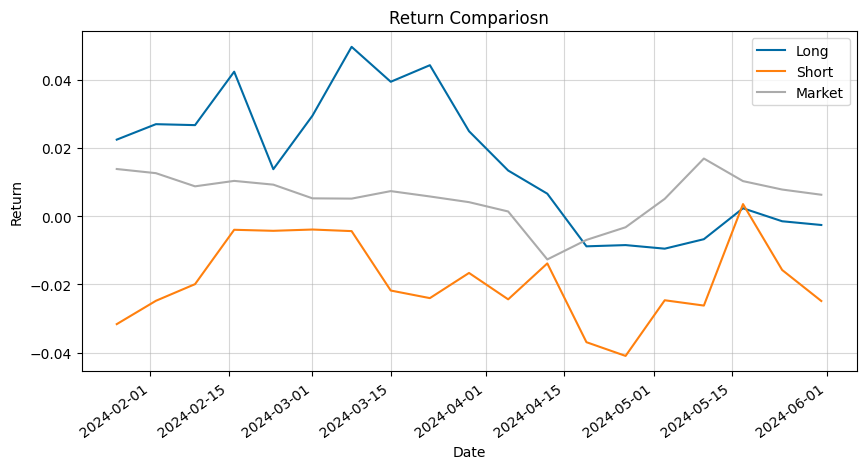

In [290]:
import matplotlib.pyplot as plt

plt.style.use(['tableau-colorblind10'])

fig, ax = plt.subplots()
# Create a new figure with the desired size
fig.set_size_inches(10, 5)

ax.plot(result_long.date,result_long.ret.rolling(Moving).mean())
ax.plot(result_short.date,result_short.ret.rolling(Moving).mean())
ax.plot(ret_mk_df.Date,ret_mk_df.ret.rolling(Moving).mean())

ax.set(title = "Return Compariosn", xlabel = "Date", ylabel="Return")

# The 'legend' function takes the labels as a list, so you need to provide them as a list
ax.legend(['Long', 'Short', "Market"])
fig.autofmt_xdate(rotation=36)

plt.grid('light-grey', alpha = 0.5)
plt.show()

In [291]:
import plotly.graph_objects as go

# Compute the rolling mean and drop NaN values
rolling_long = result_long['ret'].rolling(Moving).mean().dropna()
rolling_short = result_short['ret'].rolling(Moving).mean().dropna()
rolling_market = ret_mk_df['ret'].rolling(Moving).mean().dropna()

# Create traces with the cleaned series
trace_long = go.Scatter(x=result_long['date'][rolling_long.index], y=rolling_long, name='Long')
trace_short = go.Scatter(x=result_short['date'][rolling_short.index], y=rolling_short, name='Short')
trace_market = go.Scatter(x=ret_mk_df['Date'][rolling_market.index], y=rolling_market, name='Market')

# Create figure and add traces
fig = go.Figure(data=[trace_long, trace_short, trace_market])

# Update layout
fig.update_layout(
    title='Return Comparison',
    xaxis_title='Date',
    yaxis_title='Return',
    xaxis=dict(tickangle=36),
    width=1000,
    height=500
)

# Show the plot
fig.show()

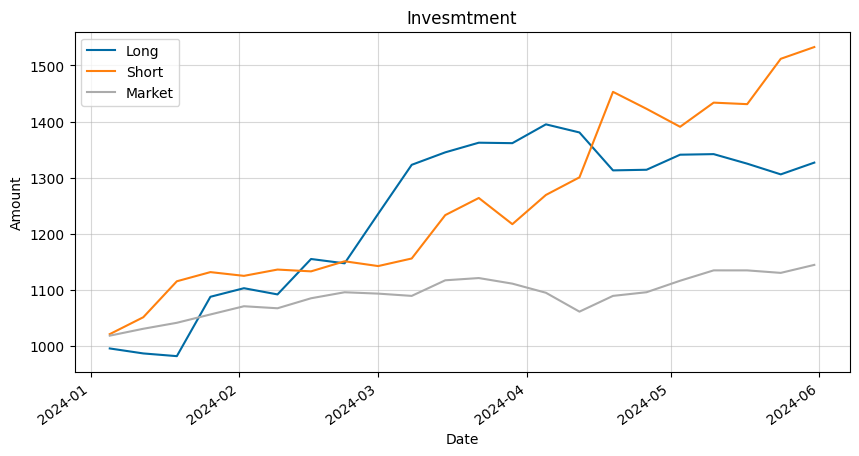

In [292]:
import matplotlib.pyplot as plt

plt.style.use(['tableau-colorblind10'])

fig, ax = plt.subplots()
# Create a new figure with the desired size
fig.set_size_inches(10, 5)

ax.plot(result_long.date,(result_long.ret + 1).cumprod()*1000)
#ax.plot(result_short.date,(result_short.ret + 1).cumprod()*1000)
ax.plot(result_short.date,(result_short.ret*-1 + 1).cumprod()*1000)

ax.plot(ret_mk_df.Date,(ret_mk_df.ret + 1).cumprod()*1000)

ax.set(title = "Invesmtment", xlabel = "Date", ylabel="Amount")

# The 'legend' function takes the labels as a list, so you need to provide them as a list
ax.legend(['Long', 'Short', "Market"])
fig.autofmt_xdate(rotation=36)

plt.grid('light-grey', alpha = 0.5)
plt.show()

In [293]:
import plotly.graph_objects as go

# Create traces
trace_long = go.Scatter(x=result_long['date'], y=(result_long['ret'] + 1).cumprod() * 1000, name='Long')
trace_short = go.Scatter(x=result_short['date'], y=(result_short['ret'] * -1 + 1).cumprod() * 1000, name='Short')
#trace_short = go.Scatter(x=result_short['date'], y=(result_short['ret'] + 1).cumprod() * 1000, name='Short')
trace_market = go.Scatter(x=ret_mk_df['Date'], y=(ret_mk_df['ret'] + 1).cumprod() * 1000, name='Market')

# Create figure and add traces
fig = go.Figure(data=[trace_long, trace_short, trace_market])

# Update layout
fig.update_layout(
    title='Investment',
    xaxis_title='Date',
    yaxis_title='Amount',
    xaxis=dict(tickangle=36),
    width=1000,
    height=500
)

# Show the plot
fig.show()